In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 400

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 0.5005
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx=10.28
        fy=10.73
        fz=40
        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
    else:
        fx=field(Ut, Uf, u[0], u[3], Ax, B)
        fy=field(Ut, Uf, u[1], u[4], Ay, B)
        fz=field(Ut, Uf, u[2], u[5], Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):
    fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
    k1 = np.dot(k1,Ut)
    fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
    k2 = np.dot(k2,(Ut+h/2*k1))
    fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
    k3 = np.dot(k3,(Ut+h/2*k2))
    fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
    k4 = np.dot(k4,(Ut+h*k3))
    a = fx;
    b = fy;
    c = fz;
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def genetico(horizonte, onda_inicial, iteracao, onda_desejada, hamiltoniano, fator_runge_kutta, tempo_analise):
    
    pop = gerar_populacao(horizonte)
    fo = calcular_func(pop, iteracao, onda_desejada, hamiltoniano, onda_inicial, horizonte, fator_runge_kutta, tempo_analise)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
    
    if ELITISMO:
        elit = []
        while len(elit) < (round(PORCENTAGEM_ELITISMO*TAMANHO_POP)):
            for posicao_populacao in range(0, len(fit)):
                if min_fit == fit_edit[posicao_populacao]:
                    elit.append(posicao_populacao)
            fit_edit.tolist().remove(min_fit)
            min_fit = min(fit_edit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])
                
        fo = calcular_func(new_pop, iteracao, onda_desejada, hamiltoniano, onda_inicial, horizonte, fator_runge_kutta, tempo_analise)
        fit = fitness(fo)
        min_fo = min(fo)
        max_fit = max(fit)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
        
        fit_edit = fit
        if ELITISMO:
            posicao = 0
            for iterator in range(0, round(PORCENTAGEM_ELITISMO*TAMANHO_POP)):
                for posicao_populacao in range(0, len(fit)):
                    if max_fit == fit_edit[posicao_populacao]:
                        posicao = posicao_populacao
                fit_edit.tolist().remove(max_fit)
                max_fit = max(fit_edit)
                new_pop = np.vstack([new_pop, pop[elit[iterator]]])
                new_pop = np.delete(new_pop, posicao, 0)
        
        pop = new_pop
        fit_edit = fit
        min_fit = min(fit)
        
        if ELITISMO:
            elit = []
            while len(elit) < (round(PORCENTAGEM_ELITISMO*TAMANHO_POP)):
                for posicao_populacao in range(0, len(fit)):
                    if min_fit == fit_edit[posicao_populacao]:
                        elit.append(posicao_populacao)
                fit_edit.tolist().remove(min_fit)
                min_fit = min(fit_edit)
                
    return pop[pos_min_fo,:][0,0]

In [8]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [9]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [10]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [11]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

############ Informações finais do experimento ############

O rf desejado é:
 [[0]
 [0]
 [1]]
O rho desejado é: [[np.float64(1.0), np.complex128(0j)], [np.complex128(0j), np.float64(0.0)]]
O vetor de Bloch encontrado é:
 [[ 0.00295032]
 [-0.00146748]
 [ 0.99747644]]
O rho alcançado foi:
 [[np.float64(0.9987382192939006), np.complex128(0.0014751624488316894+0.0007337409719532668j)], [np.complex128(0.0014751624488316894-0.0007337409719532668j), np.float64(0.0012617807060993913)]]
A fidelidade do experimento é de: (0.9993691936364639-7.110727651110962e-07j)
A fidelidade do experimento é de (fórmula dos autores do artigo): 0.9949150470096866
O vetor U alcançado foi:
 [[ 0.00295032  0.00162893  0.99803658]
 [-0.00146748 -0.99684692 -0.0012148 ]
 [ 0.99747644  0.00135521  0.00239626]]
A distância encontrada, ao final do experimento foi: 4.2731036351215544e-05

############ Informações gráficas obtidas com o experimento ############



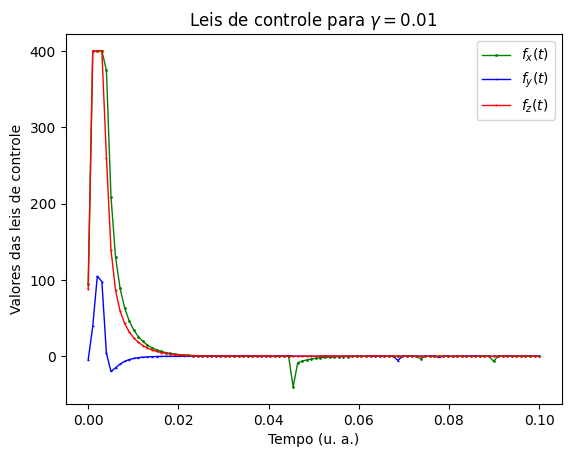

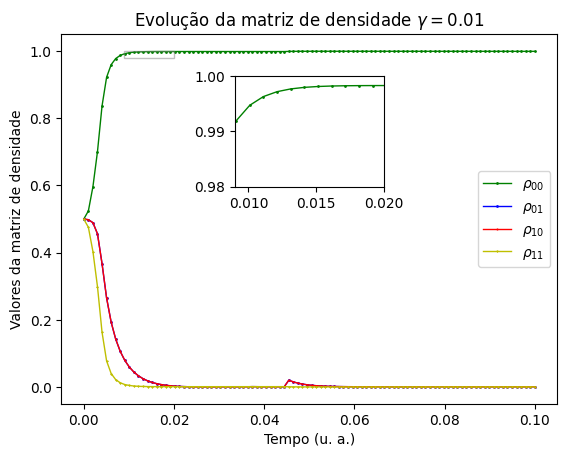

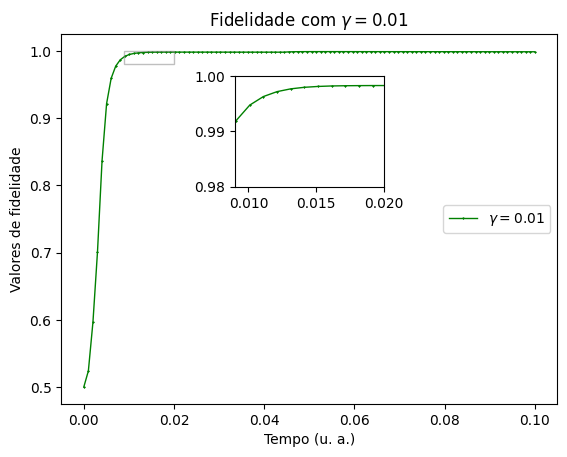

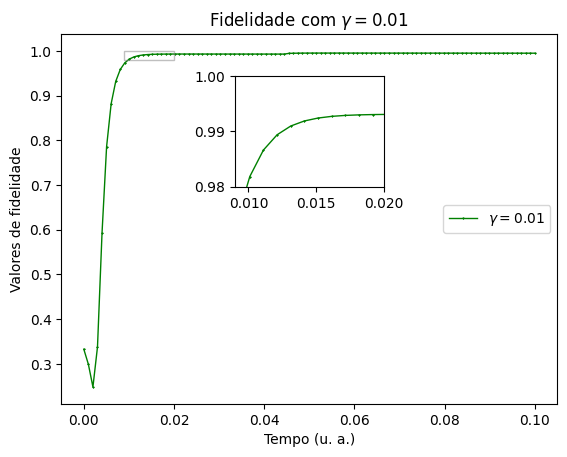

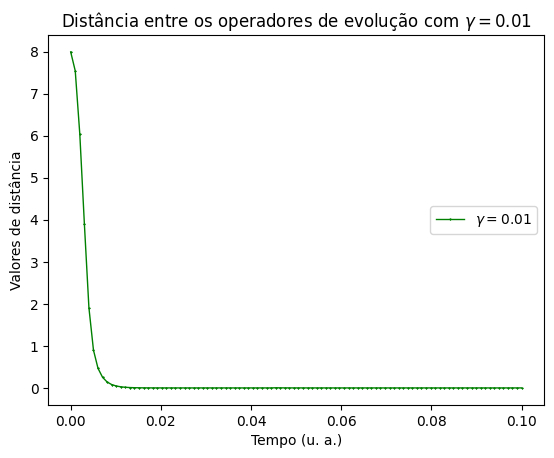

In [12]:
u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard

Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard

print(f"############ Informações finais do experimento ############\n")

r0 = [[1], [0], [0]]
rf = np.dot(Uf, r0)
print(f'O rf desejado é:\n {rf}')
pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
print(f'O rho desejado é: {pf}')

h=0.001
t=0
i=0
lbda=0.01
distance_vector = []
fx_vector = []
fy_vector = []
fz_vector = []
rho_vector = np.zeros((4,100),dtype=np.complex128)
fid_vector = []
fid_autores = []
   
while t < 100:
    a,b,c,Ut = rungeKutta(u, Ut, Uf, h, t, lbda)
    D = np.linalg.norm(Ut-Uf)**2
    distance_vector.append(D)
    fx_vector.append(a)
    fy_vector.append(b)
    fz_vector.append(c)
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    rho_vector[0][t] = pt[0][0]
    rho_vector[1][t] = pt[0][1]
    rho_vector[2][t] = pt[1][0]
    rho_vector[3][t] = pt[1][1]
    #fid_vector.append(np.trace(np.sqrt(np.sqrt(pt)*pf*np.sqrt(pt))))
    fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
    fid_autores.append((np.trace(np.dot(Ut, np.transpose(Ut)))+np.abs(np.trace(np.dot(np.transpose(Uf), Ut)))**2)/(3*(3+1)))
    t += 1

rt = np.dot(Ut, r0)
print(f'O vetor de Bloch encontrado é:\n {rt}')
pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
print(f'O rho alcançado foi:\n {pt}')
#print(f'A fidelidade do experimento é de: {np.trace(np.sqrt(np.sqrt(pt)*pf*np.sqrt(pt)))}')
print(f'A fidelidade do experimento é de: {(np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))}')
print(f'A fidelidade do experimento é de (fórmula dos autores do artigo): {(np.trace(np.dot(Ut, np.transpose(Ut)))+np.abs(np.trace(np.dot(np.transpose(Uf), Ut)))**2)/(3*(3+1))}')
print(f'O vetor U alcançado foi:\n {Ut}')
print(f'A distância encontrada, ao final do experimento foi: {D}')

print(f"\n############ Informações gráficas obtidas com o experimento ############\n")

leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
densidade(rho_vector,t,lbda)
fidelidade(fid_vector,t,lbda)
fidelidade(fid_autores,t,lbda)
distance(distance_vector,t,lbda)

In [13]:
print(f"\n############ Informações provenientes de análises gráficas ############\n")

time = 0
for i in range(len(rho_vector[0])):
    if rho_vector[0][i] == max(abs(rho_vector[0])):
        time = i
        break
print(fr"O maior valor obtido para ρ, na primeira posição da matriz, foi {max(abs(rho_vector[0]))} para o tempo de {time/1000}, com fidelidade de {np.abs(fid_vector[time])} e de acordo com a fórmula dos autores, com fidelidade de {np.abs(fid_autores[time])}")


############ Informações provenientes de análises gráficas ############

O maior valor obtido para ρ, na primeira posição da matriz, foi 0.9989599020921202 para o tempo de 0.052, com fidelidade de 0.998961091380947 e de acordo com a fórmula dos autores, com fidelidade de 0.9952041663389194


In [14]:
print(fid_autores)

[np.float64(0.33274499128472373), np.float64(0.299106196553794), np.float64(0.24849058603944105), np.float64(0.33780486096886464), np.float64(0.5933186048352109), np.float64(0.7858842405441018), np.float64(0.881945754980079), np.float64(0.9316907174144897), np.float64(0.9585242349119696), np.float64(0.9734103366142935), np.float64(0.9818137444502977), np.float64(0.9866072897488882), np.float64(0.989358149588463), np.float64(0.9909417837663229), np.float64(0.9918544852973502), np.float64(0.9923801328290406), np.float64(0.9926819919875172), np.float64(0.992854275096379), np.float64(0.9929514607628466), np.float64(0.9930050936746412), np.float64(0.993033455581214), np.float64(0.9930471546808343), np.float64(0.993052343549954), np.float64(0.9930525775559468), np.float64(0.9930499398742039), np.float64(0.9930456365277814), np.float64(0.9930403574328445), np.float64(0.9930345144342696), np.float64(0.9930286182601654), np.float64(0.993022266507372), np.float64(0.9930157915282583), np.float64(

In [15]:
print(sum(fid_autores[30:])/(len(fid_autores)-30))

0.9946099949062277


In [16]:
print(fid_vector)

[np.clongdouble('0.50052895196542616186+4.860315337929775679e-06j'), np.clongdouble('0.52438156198508179126+3.135161930340204597e-05j'), np.clongdouble('0.59660156988607847934+0.00016454795616006714463j'), np.clongdouble('0.7011718047520174763+2.668450273969398281e-13j'), np.clongdouble('0.8366371568482227412-9.825786625411149609e-05j'), np.clongdouble('0.92167497366519357847+0.0001209534975162969242j'), np.clongdouble('0.95923953786562267247+4.2409323279545499952e-05j'), np.clongdouble('0.97739241741905644574+6.334675362584044682e-05j'), np.clongdouble('0.9867766379784043398-6.5419840295250740044e-05j'), np.clongdouble('0.99191670306000362796+2.513858630194789841e-05j'), np.clongdouble('0.99471572035338014765-1.2932601218440741622e-05j'), np.clongdouble('0.9962588795800692049-4.338667571879194916e-05j'), np.clongdouble('0.9971437802446362599+3.103614879171637769e-05j'), np.clongdouble('0.99764527651164344545+1.7818242563225111643e-05j'), np.clongdouble('0.99792387737814131093-3.891415

In [17]:
print(sum(fid_vector[30:])/(len(fid_vector)-30))

(0.99870738610353461954-1.8860766209334815815e-07j)


In [18]:
print(distance_vector)

[np.float64(7.992927296916127), np.float64(7.5409722378036195), np.float64(6.036283623815107), np.float64(3.9093031351423932), np.float64(1.907363639407131), np.float64(0.8991951674886185), np.float64(0.4643623023051125), np.float64(0.25205688017630024), np.float64(0.14070910316158838), np.float64(0.07982764643123687), np.float64(0.04572200552981023), np.float64(0.02634275177976085), np.float64(0.015238539668342968), np.float64(0.0088439941246646), np.float64(0.005150412162112598), np.float64(0.0030129310935038314), np.float64(0.0017744772153929415), np.float64(0.0010563419154033238), np.float64(0.0006396878180273093), np.float64(0.00039785265184048163), np.float64(0.0002574463345918439), np.float64(0.00017593201301097566), np.float64(0.00012861047503067889), np.float64(0.0001011044951904949), np.float64(8.515239560298177e-05), np.float64(7.590727076498295e-05), np.float64(7.055743666513543e-05), np.float64(6.74738028858321e-05), np.float64(6.582980094422854e-05), np.float64(6.47472743

In [19]:
print(sum(distance_vector[80:])/(len(distance_vector)-80))

4.267633090689399e-05
